# Previsão de renda

## Etapa 1 CRISP - DM: Entendimento do negócio

Esste é um problema de ciência de dados desenvolvido como parte do aprendizaod do curso da EBAC. A base utilizada foi modificada e fornecida pela EBAC (https://ebaconline.com.br/).

A previsão de renda é um problema de ciência de dados que envolve a estimativa do nível de renda de um indivíduo ou grupo com base em características demográficas, sociais e econômicas. Esse tipo de análise é fundamental para setores como marketing, crédito e políticas públicas, pois auxilia na tomada de decisões informadas, personalização de serviços e alocação de recursos.

Essas previsões são essenciais para identificar padrões socioeconômicos, direcionar campanhas de marketing de maneira mais eficaz, avaliar riscos de crédito e entender a distribuição de riqueza em uma população.



## Etapa 2 Crisp-DM: Entendimento dos dados

Os dados estão dispostos em uma tabela com uma linha para cada cliente, e uma coluna para cada variável armazenando as características desses clientes. Colocamos uma cópia o dicionário de dados (explicação dessas variáveis) abaixo neste notebook:



### Dicionário de dado


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data da coleta dos dados                           | Object       |
| id_cliente              |  Identidifacaçõ do cliente                          | Int          |
| sexo                    |  M = 'Masculino'; F = 'Feminino'                    | Object       |
| posse_de_veiculo        |  T= 'possui'; F= 'não possui'                       | Bool         |
| posse_de_imovel         |  T= 'possui'; F= 'não possui'                       | Bool         |
| qtd_filhos              |  Quantidade de filhos                               | Int          |
| tipo_renda              |  Tipo de renda (ex: assaliariado, autônomo etc)     | Object       |
| educacao                |  Nível de escolaridade                              | Object       |
| estado_civil            |  Estado Civil                                       | Object       |
| tipo_residencia         |  Tipo de residência (casa, apartamento etc)         | Object       |
| idade                   |  Idade                                              | Int          |
| tempo_emprego           |  Tempo de emprego em anos                           | Float        |
| qt_pessoas_residencia   |  Quantidade de pessoas na residência                | Float        |
| renda                   |  Renda                                              | Float        |





#### Carregando os pacotes


In [659]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    RocCurveDisplay,
    roc_curve
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [660]:
pd.set_option('display.max_columns', None)


In [661]:
tqdm.pandas()

#### Carregando os dados


In [663]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

In [664]:
renda_1 = pd.read_csv('./input/previsao_de_renda.csv')

#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

In [666]:
prof = ProfileReport(renda, explorative=True)

In [667]:
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [668]:
prof.to_file('./output/renda_analisys.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Esse report nos dá uma visão geral sobre a interação dos dados e também destaca pontos que devem ser considerados, por exemplo:

* Temos dados missings que devem ser tratados
* Temos colunas, como "unnamed: 0" que deve ser tratada ou removida
* A quantidade de pessoas na residência tem uma correlação forte com a quantidade de filhas, o que é esperado

Esses e outros pontos serão considerados a seguir


### Entendimento dos dados - Bivariadas




In [671]:
renda['data_ref']=pd.to_datetime(renda['data_ref'], format='%Y-%m-%d')

In [672]:
renda.select_dtypes('number').corr()
#variáveis numéricas

Unnamed: 0  id_cliente  qtd_filhos     idade  \
Unnamed: 0               1.000000    0.016565   -0.002281 -0.001438   
id_cliente               0.016565    1.000000    0.030296 -0.057812   
qtd_filhos              -0.002281    0.030296    1.000000 -0.360426   
idade                   -0.001438   -0.057812   -0.360426  1.000000   
tempo_emprego            0.004102   -0.036373   -0.063220  0.321573   
qt_pessoas_residencia   -0.003191    0.037951    0.889777 -0.339320   
renda                    0.004901   -0.009129    0.029346  0.022435   

                       tempo_emprego  qt_pessoas_residencia     renda  
Unnamed: 0                  0.004102              -0.003191  0.004901  
id_cliente                 -0.036373               0.037951 -0.009129  
qtd_filhos                 -0.063220               0.889777  0.029346  
idade                       0.321573              -0.339320  0.022435  
tempo_emprego               1.000000              -0.065670  0.385013  
qt_pessoas_residencia      -0.065670               1.000000  0.047842  
renda                       0.385013               0.047842  1.000000

Principais interações com variáveis numéricas

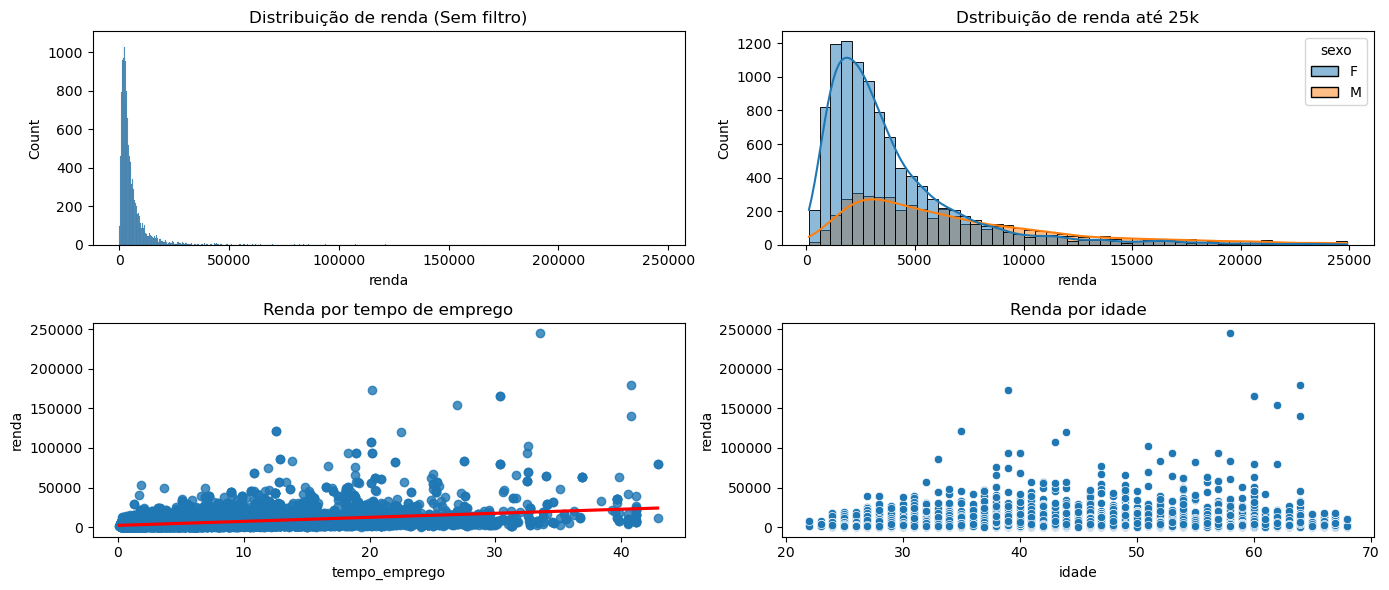

In [674]:
fig, axes = plt.subplots(2, 2, figsize = (14,6))

sns.histplot(data=renda, x='renda', ax=axes[0, 0])
axes[0, 0].set_title('Distribuição de renda (Sem filtro)')

sns.histplot(data=renda[renda['renda']<25000], x='renda', hue='sexo', ax=axes[0, 1], bins= 50, kde=True)
axes[0, 1].set_title('Dstribuição de renda até 25k')

sns.regplot(data=renda, x='tempo_emprego', y='renda', line_kws={'color':'red'}, ax=axes[1,0])
axes[1,0].set_title('Renda por tempo de emprego')


sns.scatterplot(data=renda, x='idade', y='renda', ax=axes[1,1])
axes[1,1].set_title('Renda por idade')

plt.tight_layout()
plt.show()

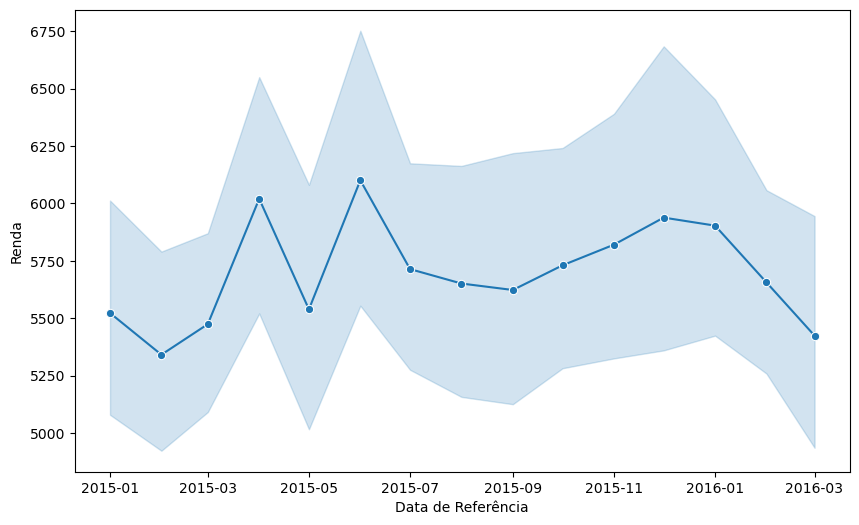

In [675]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=renda, x='data_ref', y='renda', marker='o')

# Ajustar os rótulos e o título
plt.xlabel('Data de Referência')
plt.ylabel('Renda')

# Exibir o gráfico
plt.show()

* Os valores de renda apresentam uma distribuição não gaussiana
* O tempo de emprego apresentou a maior correlação positiva (ainda que fraca) dentre as variáveis numéricas
* A idade não é um fator determinante para previsão da renda

In [677]:
renda.select_dtypes(include=['object', 'bool']).head(5)

sexo  posse_de_veiculo  posse_de_imovel        tipo_renda  \
0    F             False             True        Empresário   
1    M              True             True       Assalariado   
2    F              True             True        Empresário   
3    F             False             True  Servidor público   
4    M              True            False       Assalariado   

            educacao estado_civil tipo_residencia  
0         Secundário     Solteiro            Casa  
1  Superior completo       Casado            Casa  
2  Superior completo       Casado            Casa  
3  Superior completo       Casado            Casa  
4         Secundário     Solteiro   Governamental

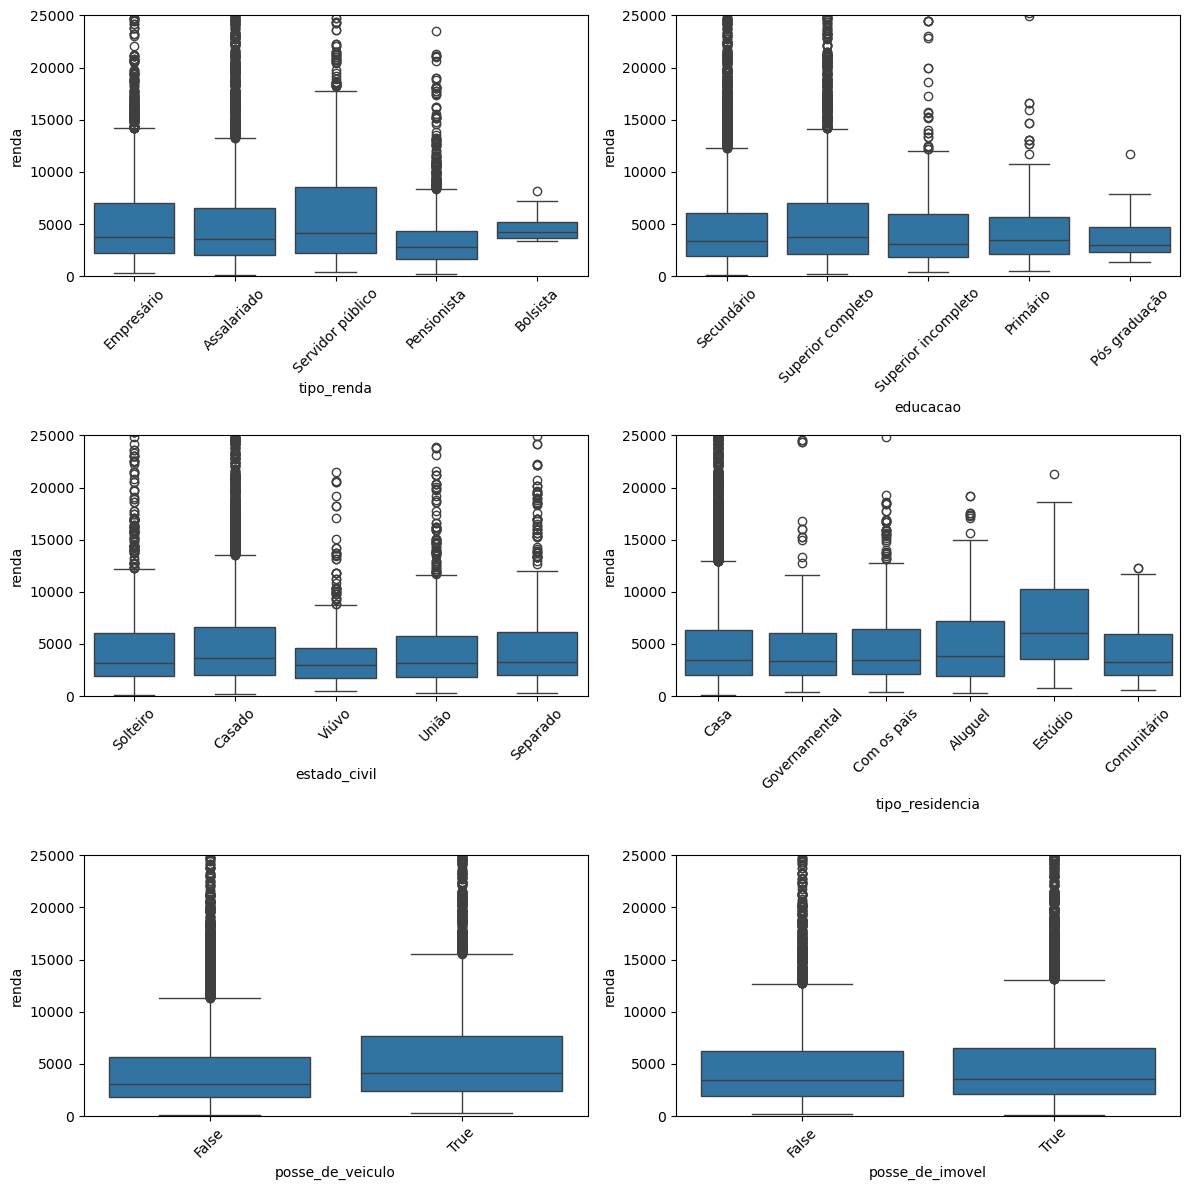

In [678]:
fig, axes = plt.subplots(3, 2, figsize=(12,12))

sns.boxplot(data=renda, x= 'tipo_renda', y='renda', ax=axes[0,0])

sns.boxplot(data=renda, x= 'educacao', y='renda', ax=axes[0,1])

sns.boxplot(data=renda, x= 'estado_civil', y='renda', ax=axes[1,0])

sns.boxplot(data=renda, x= 'tipo_residencia', y='renda', ax=axes[1,1])

sns.boxplot(data=renda, x= 'posse_de_veiculo', y='renda', ax=axes[2,0])

sns.boxplot(data=renda, x= 'posse_de_imovel', y='renda', ax=axes[2,1])




for ax in axes.flatten():
    ax.set_ylim(0, 25000)
    for label in ax.get_xticklabels():
        label.set_rotation(45)



        
plt.tight_layout()
plt.show()

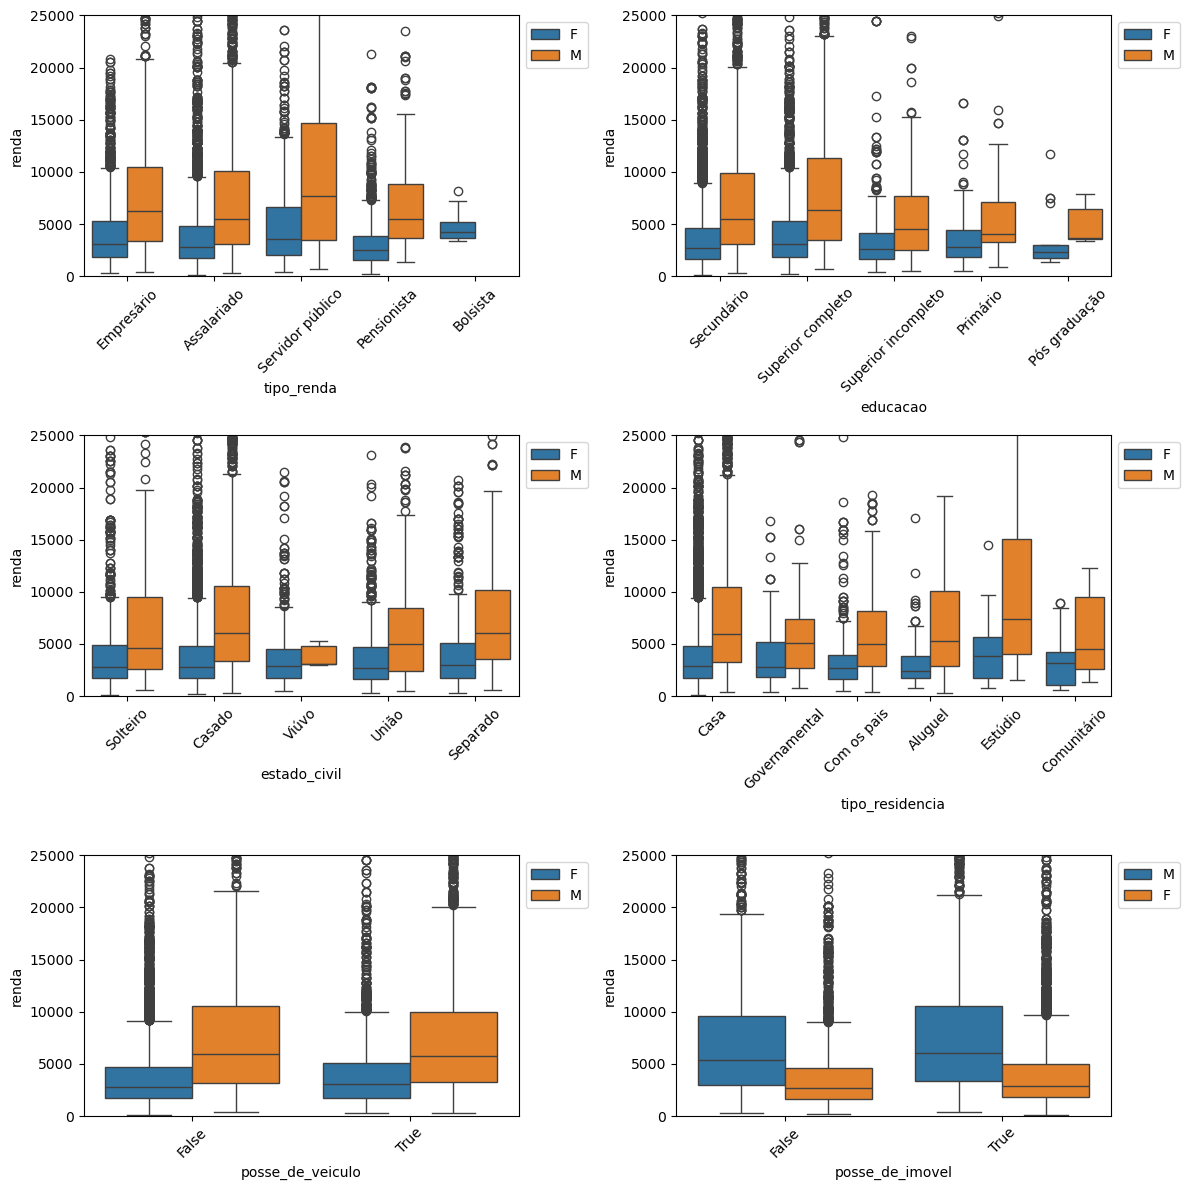

In [679]:
fig, axes = plt.subplots(3, 2, figsize=(12,12))

sns.boxplot(data=renda, x= 'tipo_renda', y='renda', hue = 'sexo', ax=axes[0,0])

sns.boxplot(data=renda, x= 'educacao', y='renda', hue= 'sexo', ax=axes[0,1])

sns.boxplot(data=renda, x= 'estado_civil', y='renda', hue= 'sexo', ax=axes[1,0])

sns.boxplot(data=renda, x= 'tipo_residencia', y='renda', hue= 'sexo', ax=axes[1,1])

sns.boxplot(data=renda, x= 'posse_de_veiculo', y='renda', hue= 'sexo', ax=axes[2,0])

sns.boxplot(data=renda, x= 'posse_de_imovel', y='renda', hue= 'sexo', ax=axes[2,1])


for ax in axes.flatten():
    ax.set_ylim(0, 25000)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))



        
plt.tight_layout()
plt.show()


In [680]:
renda.groupby('sexo')['renda'].mean()

sexo
F    4060.583289
M    9090.404333
Name: renda, dtype: float64

In [681]:
renda.tipo_renda.value_counts()

tipo_renda
Assalariado         7633
Empresário          3508
Pensionista         2582
Servidor público    1268
Bolsista               9
Name: count, dtype: int64

* O tipo de renda 'bolsista' parecia ser um indicador interessante para a previsão de renda, no entanto, olhando mais detalhadamente, a quantidade de bolsistas é bem menor do que das outras categorias
* A base apresenta o dobro de indivíduos do sexo feminino, no entanto, a média de renda de homens é mais que o dobro do que de mulheres.
* Indivíduos com ensino superior completo e posse de veículos parecem apresentar a renda média ligeiramente superior 
* No geral, os dados categóricos isolados não representam forte poder preditivo para a renda

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



In [684]:
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15000 non-null  int64         
 1   data_ref               15000 non-null  datetime64[ns]
 2   id_cliente             15000 non-null  int64         
 3   sexo                   15000 non-null  object        
 4   posse_de_veiculo       15000 non-null  bool          
 5   posse_de_imovel        15000 non-null  bool          
 6   qtd_filhos             15000 non-null  int64         
 7   tipo_renda             15000 non-null  object        
 8   educacao               15000 non-null  object        
 9   estado_civil           15000 non-null  object        
 10  tipo_residencia        15000 non-null  object        
 11  idade                  15000 non-null  int64         
 12  tempo_emprego          12427 non-null  float64       
 13  q

In [685]:
renda.drop('Unnamed: 0', axis=1, inplace=True)

In [686]:
renda.isna().sum()

data_ref                    0
id_cliente                  0
sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64

In [687]:
renda[pd.isna(renda['tempo_emprego']) & (renda['tipo_renda'] == 'Pensionista')]

data_ref  id_cliente sexo  posse_de_veiculo  posse_de_imovel  \
11    2015-01-01        6881    F             False             True   
12    2015-01-01        2448    F             False             True   
21    2015-01-01         698    F              True             True   
22    2015-01-01       11948    F             False             True   
23    2015-01-01       11184    F              True             True   
...          ...         ...  ...               ...              ...   
14979 2016-03-01        3578    F              True             True   
14984 2016-03-01        5088    F              True             True   
14986 2016-03-01        5831    F             False            False   
14991 2016-03-01        1156    M             False             True   
14996 2016-03-01        3722    F             False             True   

       qtd_filhos   tipo_renda             educacao estado_civil  \
11              0  Pensionista           Secundário       Casado   
12              0  Pensionista           Secundário        Viúvo   
21              0  Pensionista  Superior incompleto       Casado   
22              0  Pensionista           Secundário        Viúvo   
23              0  Pensionista           Secundário       Casado   
...           ...          ...                  ...          ...   
14979           1  Pensionista           Secundário       Casado   
14984           0  Pensionista           Secundário       Casado   
14986           0  Pensionista           Secundário       Casado   
14991           0  Pensionista           Secundário       Casado   
14996           0  Pensionista    Superior completo     Solteiro   

      tipo_residencia  idade  tempo_emprego  qt_pessoas_residencia     renda  
11               Casa     65            NaN                    2.0   1685.51  
12               Casa     60            NaN                    1.0   6343.52  
21               Casa     58            NaN                    2.0   1649.37  
22               Casa     61            NaN                    1.0   4715.57  
23               Casa     59            NaN                    2.0    799.18  
...               ...    ...            ...                    ...       ...  
14979            Casa     56            NaN                    3.0   4672.65  
14984            Casa     55            NaN                    2.0   1235.34  
14986            Casa     59            NaN                    2.0   2410.18  
14991            Casa     62            NaN                    2.0   5153.15  
14996            Casa     57            NaN                    1.0  10093.45  

[2573 rows x 14 columns]

In [688]:
renda[pd.isna(renda['tempo_emprego']) & (renda['tipo_renda'] == 'Pensionista') & (renda['educacao'] == 'Superior completo')]

data_ref  id_cliente sexo  posse_de_veiculo  posse_de_imovel  \
71    2015-01-01        2667    F             False             True   
132   2015-01-01       13393    F              True            False   
161   2015-01-01       16590    F              True             True   
167   2015-01-01        2443    F             False            False   
201   2015-01-01       10995    F             False            False   
...          ...         ...  ...               ...              ...   
14910 2016-03-01        5984    M              True             True   
14930 2016-03-01        8950    F             False             True   
14941 2016-03-01        2831    F              True             True   
14971 2016-03-01       10010    M             False             True   
14996 2016-03-01        3722    F             False             True   

       qtd_filhos   tipo_renda           educacao estado_civil  \
71              0  Pensionista  Superior completo       Casado   
132             0  Pensionista  Superior completo        Viúvo   
161             0  Pensionista  Superior completo       Casado   
167             0  Pensionista  Superior completo        Viúvo   
201             0  Pensionista  Superior completo       Casado   
...           ...          ...                ...          ...   
14910           0  Pensionista  Superior completo       Casado   
14930           0  Pensionista  Superior completo       Casado   
14941           0  Pensionista  Superior completo     Separado   
14971           0  Pensionista  Superior completo       Casado   
14996           0  Pensionista  Superior completo     Solteiro   

      tipo_residencia  idade  tempo_emprego  qt_pessoas_residencia     renda  
71               Casa     60            NaN                    2.0   4817.12  
132              Casa     57            NaN                    1.0   1849.31  
161              Casa     57            NaN                    2.0   6540.02  
167              Casa     58            NaN                    1.0   2836.10  
201              Casa     61            NaN                    2.0   2311.97  
...               ...    ...            ...                    ...       ...  
14910            Casa     66            NaN                    2.0   4004.86  
14930            Casa     60            NaN                    2.0   3715.49  
14941            Casa     59            NaN                    1.0   3929.36  
14971            Casa     67            NaN                    2.0   4950.70  
14996            Casa     57            NaN                    1.0  10093.45  

[640 rows x 14 columns]

* Considerando que os indivíduos com dados missings no 'tempo_emprego' têm tipo de renda pensionista e, em sua maioria, um grau de educação de superior incompleto ou inferior, consideraremos esses missings como 0 anos em 'tempo_emprego'

In [690]:
renda = renda.fillna(0)

* Criando variáveis categóricas para identificar relações não lineares

In [692]:
def categorizar_tempo_emprego(tempo):
    if 0 <= tempo<0.1:
        return '0 anos'
    elif 0.1 < tempo < 5:
        return '1 a 4.99 anos'
    elif 5 < tempo < 10:
        return '5 a 10 anos'
    elif 10 < tempo < 15:
        return '10 a 15 anos'
    elif 15 < tempo:
        return '15 anos ou mais'
    return tempo

renda['tempo_emprego_categorico'] = renda['tempo_emprego'].apply(categorizar_tempo_emprego)

In [693]:
def categorize_filhos(qtd):
    if qtd == 0:
        return '0 filhos'
    elif 1 <= qtd <= 2:
        return '1-2 filhos'
    else:
        return '3 ou mais filhos'

renda['categoria_filhos'] = renda['qtd_filhos'].apply(categorize_filhos)

In [694]:
bins = [0, 25, 30, 40, 50, 60, 100]  # Definindo os limites das categorias
labels = ['<25 anos', '<=25 e <30 anos', '<=30 e <40 anos', '<=40 e <50 anos', '<=50 e <=0 anos', '>60 anos']  # Nomes das categorias
renda['faixa_idade'] = pd.cut(renda['idade'], bins=bins, labels=labels, right=False)

In [695]:
tabela = renda.groupby(['tempo_emprego_categorico'], observed=False)[['renda']].agg(
    renda_media=('renda', 'mean'),
    renda_mediana=('renda', 'median'),
    renda_desvio_padrao=('renda', 'std')
).round(2)
tabela

tabela.sort_values(by='renda_media', ascending=True)

renda_media  renda_mediana  renda_desvio_padrao
tempo_emprego_categorico                                                 
0 anos                        3672.39        2777.15              3428.61
1 a 4.99 anos                 3799.01        2824.67              3363.57
5 a 10 anos                   5549.81        3744.32              5425.23
10 a 15 anos                  8232.50        5164.80              9853.58
15 anos ou mais              13101.14        7077.92             18283.98

In [696]:
renda.groupby([ 'educacao','posse_de_veiculo','tempo_emprego_categorico'], observed=False)[['renda']].mean()

renda
educacao            posse_de_veiculo tempo_emprego_categorico              
Primário            False            0 anos                     3799.402000
                                     1 a 4.99 anos              3675.457222
                                     10 a 15 anos              16131.507500
                                     15 anos ou mais           16588.650000
                                     5 a 10 anos                4403.236286
                    True             0 anos                     4376.138571
                                     1 a 4.99 anos              2518.555217
                                     10 a 15 anos              10305.702857
                                     15 anos ou mais            5450.578333
                                     5 a 10 anos                5521.442500
Pós graduação       False            5 a 10 anos                5095.767778
                    True             1 a 4.99 anos              3355.828235
Secundário          False            0 anos                     3160.395870
                                     1 a 4.99 anos              3386.878128
                                     10 a 15 anos               6313.282428
                                     15 anos ou mais           11921.174368
                                     5 a 10 anos                4212.976299
                    True             0 anos                     4418.271940
                                     1 a 4.99 anos              4052.817276
                                     10 a 15 anos              10114.419596
                                     15 anos ou mais           17175.253072
                                     5 a 10 anos                6996.817275
Superior completo   False            0 anos                     4136.521974
                                     1 a 4.99 anos              3581.218059
                                     10 a 15 anos               8119.351714
                                     15 anos ou mais           11320.385296
                                     5 a 10 anos                5159.937939
                    True             0 anos                     5018.028771
                                     1 a 4.99 anos              4527.932176
                                     10 a 15 anos              10100.408508
                                     15 anos ou mais           14777.436350
                                     5 a 10 anos                6718.928588
Superior incompleto False            0 anos                     2736.794375
                                     1 a 4.99 anos              3396.542836
                                     10 a 15 anos               5247.461739
                                     15 anos ou mais            9418.856087
                                     5 a 10 anos                3811.956496
                    True             0 anos                     1623.022000
                                     1 a 4.99 anos              3847.265652
                                     10 a 15 anos               5868.567333
                                     15 anos ou mais           13075.578333
                                     5 a 10 anos                6933.652877

* Ao separar o tempo de emprego em variáveis categórias, a influência dessa variável parece mais "clara"
* A posse de veículos aliada ao tempo de emprego e escolaridade, parece ser um indicador mais forte da previsão de renda

## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


### Modelo de regressão linear

Treinamento MSE: 53643120.25768659, R²: 0.22699852021959377
Teste MSE: 51920808.33702342, R²: 0.21137142575900558


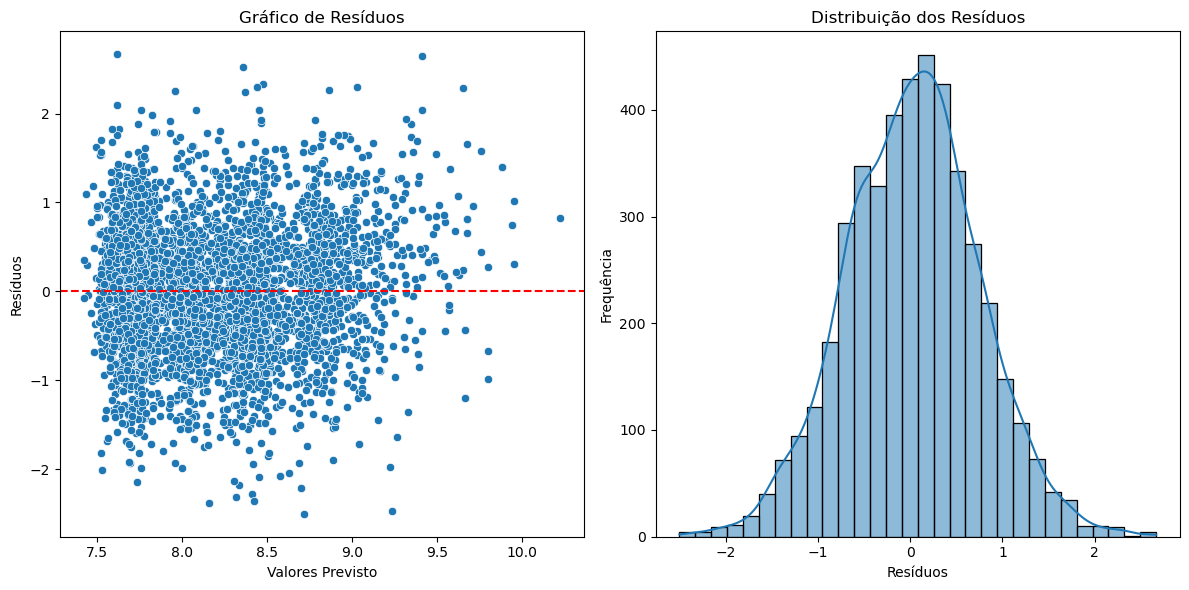

In [700]:
dummies=renda
dummies.drop(['data_ref', 'id_cliente'], axis=1, inplace=True)
dummies=pd.get_dummies(dummies, drop_first=True)

#Transformação da renda em log
dummies['renda_log'] = np.log(renda['renda'])


df_numerico = dummies.select_dtypes(include=['float64', 'int64'])
df_numerico.drop(['renda', 'renda_log'], axis=1,inplace=True)
# Padronizando os dados

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numerico)

# Aplicando PCA
pca = PCA(n_components=2)  # Escolhendo 2 componentes principais
df_pca = pca.fit_transform(df_scaled)

# Convertendo para DataFrame
df_pca = pd.DataFrame(data=df_pca, columns=['Componente 1', 'Componente 2'])

df_final = pd.concat([dummies.select_dtypes(include='bool').reset_index(drop=True), df_pca.reset_index(drop=True)], axis=1)

# Separando recursos e alvo
X = df_final # Recursos
y = dummies['renda_log']  # Target

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinamento do modelo Lasso
model_lasso = Lasso(alpha=0.01, max_iter=10000)
model_lasso.fit(X_train, y_train)

# Previsões
y_train_pred = model_lasso.predict(X_train)
y_test_pred = model_lasso.predict(X_test)

# Retornando as previsões à escala original
y_train_pred_original = np.exp(y_train_pred)
y_test_pred_original = np.exp(y_test_pred)

# Avaliação do desempenho
train_mse = mean_squared_error(np.exp(y_train), y_train_pred_original)
test_mse = mean_squared_error(np.exp(y_test), y_test_pred_original)
train_r2 = r2_score(np.exp(y_train), y_train_pred_original)
test_r2 = r2_score(np.exp(y_test), y_test_pred_original)

print(f'Treinamento MSE: {train_mse}, R²: {train_r2}')
print(f'Teste MSE: {test_mse}, R²: {test_r2}')

# 1. Verificação de Overfitting
if train_r2 - test_r2 > 0.1:
    print("Possível overfitting detectado.")

# 2. Análise de Resíduos
residuos = y_test - y_test_pred

# Gráfico de Resíduos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_pred, y=residuos)
plt.axhline(0, color='red', linestyle='--')
plt.title('Gráfico de Resíduos')
plt.xlabel('Valores Previsto')
plt.ylabel('Resíduos')

plt.subplot(1, 2, 2)
sns.histplot(residuos, bins=30, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

In [701]:
X=X.drop(['Componente 1', 'Componente 2'], axis=1)


In [702]:
### Modelo de Random Forest

In [703]:
# Divisão dos dados (X são as features, y é a variável alvo em log)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Criar o modelo de Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=60, random_state=42, max_depth = 6)

# 4. Treinar o modelo com os dados de treino
rf_model.fit(X_train, y_train)

# 5. Fazer previsões nos dados de teste
y_pred_log = rf_model.predict(X_test)  # Previsões em log(y)

# 6. Reverter a transformação de log para obter os valores originais de y
y_pred = np.exp(y_pred_log)  # Aplicar a exponencial inversa para desfazer o log
y_test_orig = np.exp(y_test)  # Também aplicamos a exponencial no y_test para comparação

# 7. Avaliar o desempenho do modelo em termos de erro
mse = mean_squared_error(y_test_orig, y_pred)
mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)  # Cálculo do R²

# 8. Exibir os resultados
print(f"Erro quadrático médio (MSE): {mse:.4f}")
print(f"Erro absoluto médio (MAE): {mae:.4f}")
print(f"Coeficiente de determinação (R²): {r2:.4f}")

Erro quadrático médio (MSE): 44955388.7908
Erro absoluto médio (MAE): 3092.0598
Coeficiente de determinação (R²): 0.3172


### Modelo Random Tree Regressor

In [705]:
#Árvore de regressão

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regr_1 = DecisionTreeRegressor()

# Definir o grid de hiperparâmetros
param_grid = {
    'max_depth': [None, 2, 5, 10,15],
    'min_samples_split': [50, 100, 200, 400, 1000],
    'min_samples_leaf': [50, 100, 300, 600, 900]
}

# Usar GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(estimator=regr_1, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Obter os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros:", best_params)



Melhores parâmetros: {'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 200}


In [706]:
# Fazer o fit do modelo usando os melhores parâmetros
best_model = grid_search.best_estimator_

# Ajustar o modelo aos dados de treinamento
best_model.fit(X_train, y_train)

predictions_log=best_model.predict(X_test)

predictions = np.exp(predictions_log)

y_test_original = np.exp(y_test)


# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print("RMSE:", rmse)

r2_original = r2_score(y_test_original, predictions)
print("R^2 na escala original:", r2_original)



RMSE: 6960.835585710234
R^2 na escala original: 0.26404067013091725


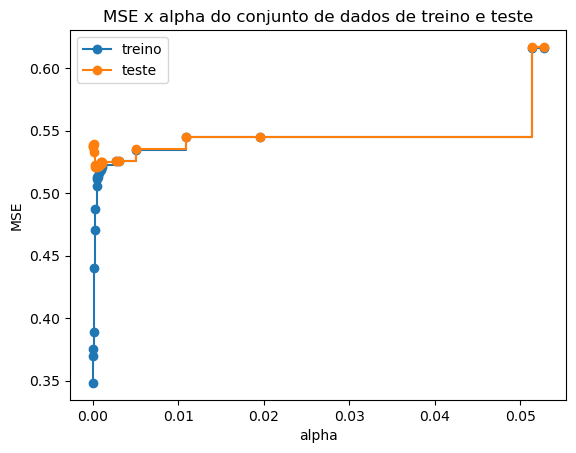

In [707]:
path=best_model.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities


clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = [mean_squared_error(y_train , clf.predict(X_train)) for clf in clfs]
test_scores  = [mean_squared_error(y_test  , clf.predict(X_test )) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [708]:
arvore_final=DecisionTreeRegressor(random_state=0, ccp_alpha=0.001)
arvore_final.fit(X_train, y_train)

print(f"Profundidade: {arvore_final.tree_.max_depth}")
print(f"R-Quadrado na base de testes: {arvore_final.score(X_test, y_test):.2f}")
print(f"MSE na base de testes: {mean_squared_error(y_test, arvore_final.predict(X_test)):.2f}")
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

Profundidade: 5
R-Quadrado na base de testes: 0.33
MSE na base de testes: 0.52
RMSE: 5330.012023163928


### Solução Alternativa #1 (Variável resposta binária)

In [710]:
renda['renda'].median()

3499.72

In [711]:
def renda_acima_media(renda):
    if renda < 3500:
        return '0'
    else:
        return '1'
renda['renda_acima_media'] = renda['renda'].apply(renda_acima_media)   

In [712]:
y=renda.renda_acima_media

In [713]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   posse_de_veiculo                          15000 non-null  bool 
 1   posse_de_imovel                           15000 non-null  bool 
 2   sexo_M                                    15000 non-null  bool 
 3   tipo_renda_Bolsista                       15000 non-null  bool 
 4   tipo_renda_Empresário                     15000 non-null  bool 
 5   tipo_renda_Pensionista                    15000 non-null  bool 
 6   tipo_renda_Servidor público               15000 non-null  bool 
 7   educacao_Pós graduação                    15000 non-null  bool 
 8   educacao_Secundário                       15000 non-null  bool 
 9   educacao_Superior completo                15000 non-null  bool 
 10  educacao_Superior incompleto              15000 non-null  

In [714]:
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Melhores parâmetros: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
Acurácia: 0.6991
Precisão: 0.7253
Recall: 0.6568
F1 Score: 0.6893
ROC AUC: 0.7543


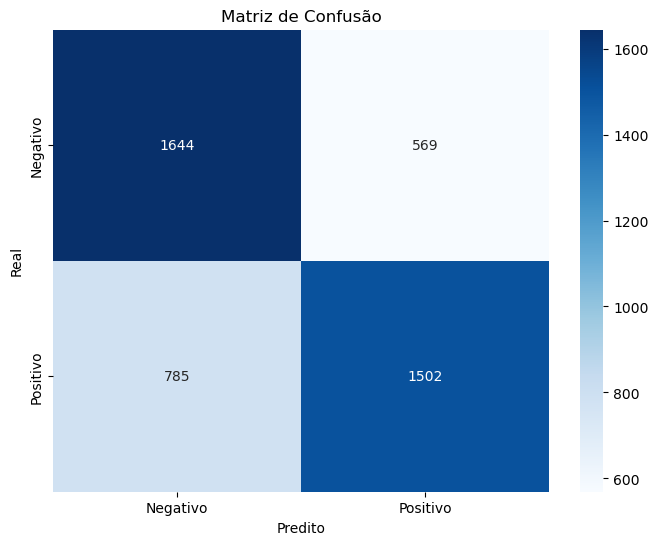

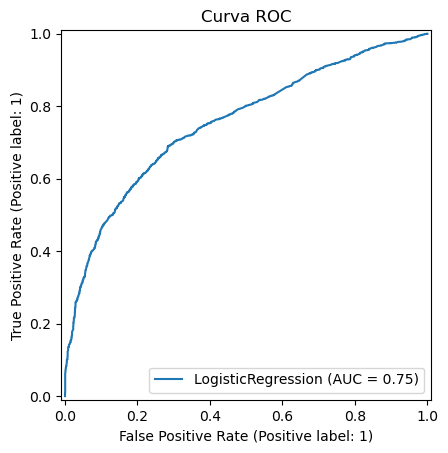

In [715]:
# Modelo de Regressão Logística
log_reg = LogisticRegression(random_state=11)


# Definir os hiperparâmetros para ajuste
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 300],
    'solver': ['liblinear', 'lbfgs']
}

# Criar o GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='accuracy', cv=5)

# Ajustar o GridSearchCV aos dados de treinamento
grid_search.fit(X_train, y_train)

# Exibir os melhores parâmetros encontrados
print(f"Melhores parâmetros: {grid_search.best_params_}")

# Fazer previsões com o melhor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Avaliar as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibir as métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Plotar a curva ROC
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Curva ROC')
plt.show()

### Solução Alternativa #2 (Variável resposta binária, dados "brutos")

Aqui usei os dados "brutos" para comparar com o modelo anterior, que usou os dados transformados

In [718]:
def renda_acima_media(renda):
    if renda < 3500:
        return '0'
    else:
        return '1'
renda_1['renda_acima_media'] = renda_1['renda'].apply(renda_acima_media)   

In [719]:
renda_1.dropna(inplace=True)

In [720]:
renda_1.drop(['Unnamed: 0', 'data_ref', 'id_cliente'], axis=1, inplace=True)

In [721]:
X=renda_1.drop(['renda', 'renda_acima_media'], axis=1)
y=renda_1.renda_acima_media

In [722]:
X=pd.get_dummies(X, drop_first=True)

In [723]:
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Melhores parâmetros: {'C': 1, 'max_iter': 100, 'solver': 'liblinear'}
Acurácia: 0.6911
Precisão: 0.6970
Recall: 0.7050
F1 Score: 0.7009
ROC AUC: 0.7626


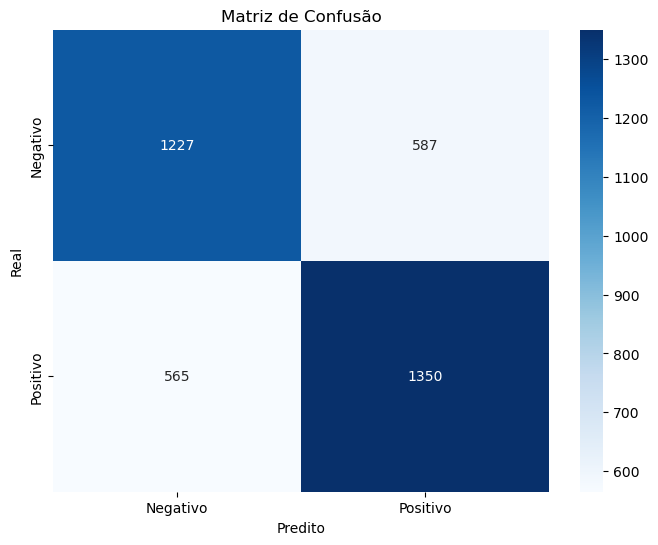

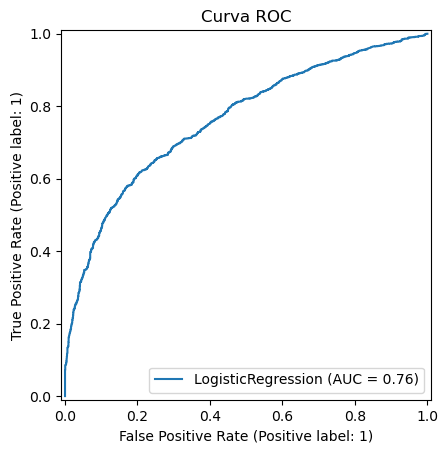

In [724]:
# Modelo de Regressão Logística
log_reg = LogisticRegression(random_state=11, max_iter=200)


# Definir os hiperparâmetros para ajuste
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 300],
    'solver': ['liblinear', 'lbfgs']
}

from sklearn.preprocessing import StandardScaler

# Escalonar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajustar o modelo aos dados escalonados


# Criar o GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='accuracy', cv=5)

# Ajustar o GridSearchCV aos dados de treinamento
grid_search.fit(X_train_scaled, y_train)

# Exibir os melhores parâmetros encontrados
print(f"Melhores parâmetros: {grid_search.best_params_}")

# Fazer previsões com o melhor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Avaliar as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibir as métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Plotar a curva ROC
RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.title('Curva ROC')
plt.show()

### Solução Alternativa #3 (Variável resposta binária, dados "brutos", XGBoost)

Acurácia: 0.7371949584338965
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1764
           1       0.77      0.72      0.74      1965

    accuracy                           0.74      3729
   macro avg       0.74      0.74      0.74      3729
weighted avg       0.74      0.74      0.74      3729

AUC ROC: 0.8151432668062984


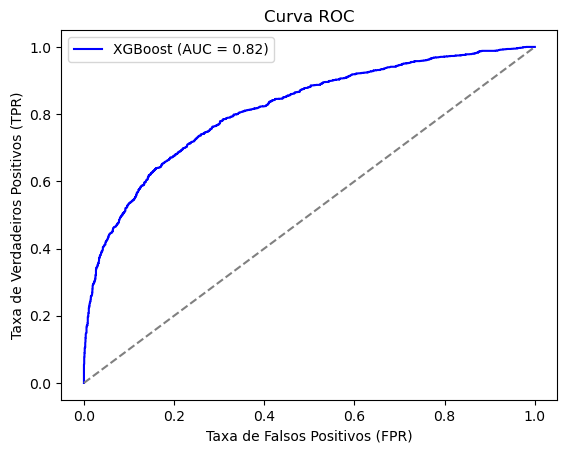

In [726]:
X = renda_1.drop(['posse_de_imovel', 'qtd_filhos', 'tipo_residencia', 'qt_pessoas_residencia', 'renda', 'renda_acima_media'], axis=1)

y=renda_1.renda_acima_media

X=pd.get_dummies(X, drop_first=True)

y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report

# Inicializando o modelo XGBoost
model = XGBClassifier(eval_metric='logloss')

# Treinando o modelo
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de classificação:")
print(classification_report(y_test, y_pred))

# Calculando a ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC ROC:", roc_auc)

# Plotando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='blue', label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()

plt.savefig("previsao_alternativa.png")  # Salva na mesma pasta que o código

plt.show()

## Etapa 5 Crisp-DM: Avaliação dos resultados


#### Neste projeto, foram testados alguns algoritmos de aprendizado de máquina supervisionado, dentre eles: Regressão linear, Random Forest, Decision Tree Regressor e, como solução alternativa, Regressão logística

* Como demonstrado ao longo do caminho, os modelos de predição da varíavel renda numa escala contínua (mesmo aplicando transformações para melhorar o algoritmo), tiveram um desempenho ruim
* Como solução alternativa, foi determinado o valor da mediana da 'renda' e, assim, criei uma variável resposta binária: "o indivíduo tem a renda acima da linha mediana ou não?"
* Ao testar essa solução, o modelo de XGBoost com a variável binária utilizando dados sem transformações apresentou um desempenho melhor do que todas as outras soluções propostas, tendo como parâmetros:

| Métrica     | Valor |
|-------------|-------|
| Acurácia    | 0.73  |
| Precisão    | 0.74  |
| Recall      | 0.74  |
| F1 Score    | 0.74  |
| ROC AUC     | 0.82  |
  


## Etapa 6 Crisp-DM: Implantação

https://github.com/LeonardoSzalo/Previsao-Renda